<a href="https://colab.research.google.com/github/Ol8410/Datasets/blob/master/%D0%A0%D0%B0%D0%B7%D0%BB%D0%B8%D1%87%D0%BD%D1%8B%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D0%B8_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Различные модели классификации (пакетирование/Бустинг)**

In [1]:
#импорт базовых библиотек

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split

# рассчитать показатели точности и матрицу путаницы
from sklearn import metrics

# игнорировать предупреждения

import warnings
warnings.filterwarnings('ignore')

In [2]:
#загрузка данных
bank_df = pd.read_csv("/content/drive/MyDrive/bank-full.csv")

In [3]:
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  Target     45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Атрибут 'Duration' значительно влияет на цель вывода (например, если duration=0, то y='no'). Тем не менее, продолжительность не известна до выполнения вызова. Кроме того, после окончания вызова y, очевидно, известен. Таким образом, эти входные данные должны быть включены только для целей сравнения и должны быть отброшены, если намерение состоит в том, чтобы иметь реалистичную прогностическую модель.

In [5]:
bank_df.drop(['duration'], inplace=True, axis=1)

Некоторые переменные более релевантны, если они являются категориальными переменными, чем числовые переменные. Таким образом преобразуем категориальные переменные в числовые переменные

In [6]:
bank_df['day']=bank_df['day'].astype('category')
bank_df['Target']=bank_df['Target'].astype('category')

**Предварительный анализ данных**

- Одномерный анализ - прямоугольная диаграмма / гистограмма для числовых переменных

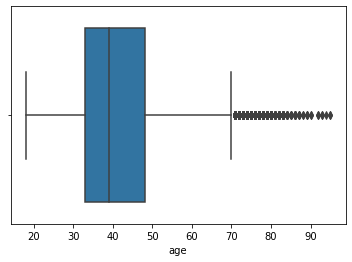

In [7]:
sns.boxplot(x=bank_df['age'], data=bank_df)

В столбце "Возраст" есть некоторые отклонения. Средний возраст составляет около 40 лет. Есть некоторый возраст старше 90 лет. Необходимо проверить данные

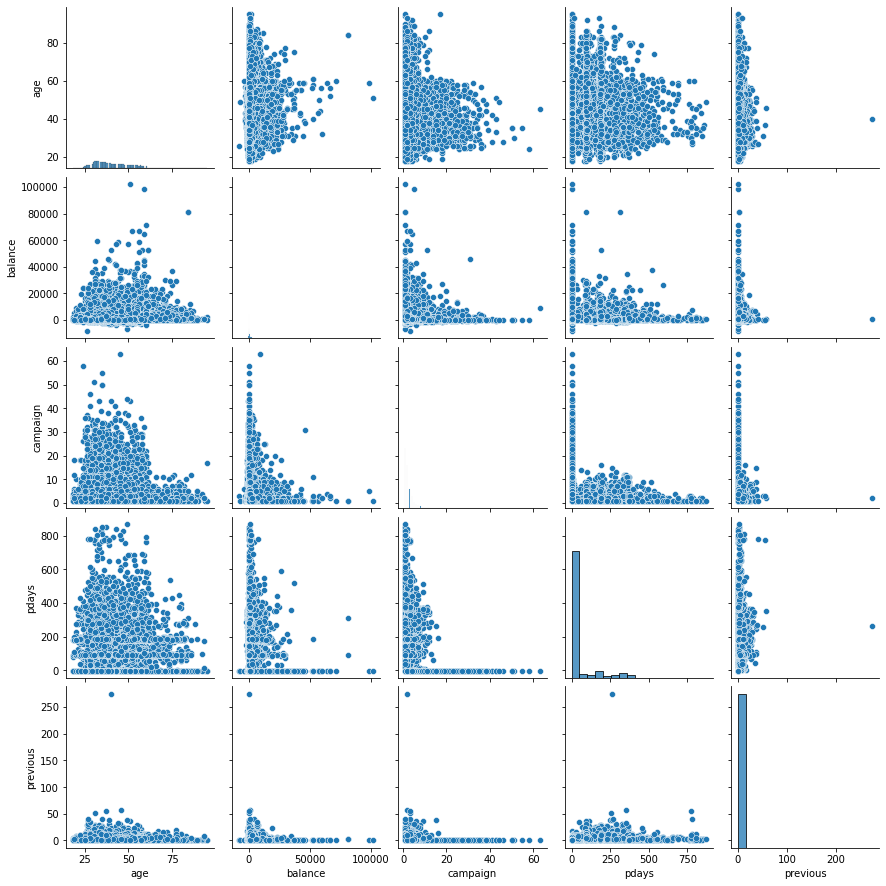

In [8]:
#гистограммы парных графиков
sns.pairplot(bank_df)

Распределение всех числовых переменных, кроме возраста, искажение - следовательно, можно преобразовать или связать некоторые из этих переменных

**Одномерный анализ - график подсчета / подсчет значений для категориальных переменных**

In [9]:
bank_df['job'].value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

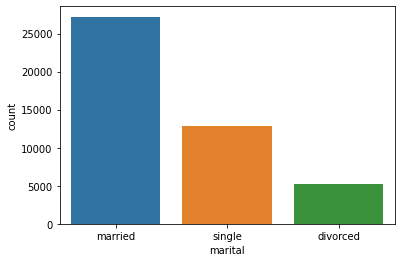

In [10]:
sns.countplot(bank_df['marital'])

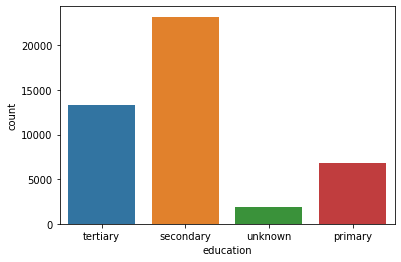

In [11]:
sns.countplot(bank_df['education'])

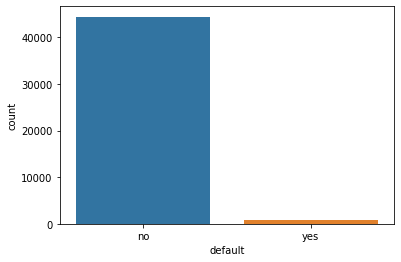

In [12]:
sns.countplot(bank_df['default'])

Для атрибута "По умолчанию" -> Да - это очень маленький %, поэтому мы можем рассмотреть возможность удаления этого столбца

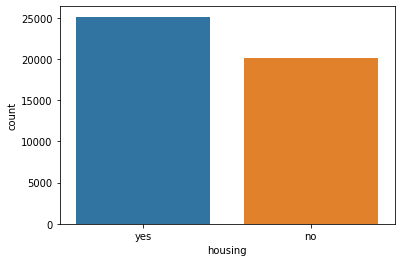

In [13]:
sns.countplot(bank_df['housing'])

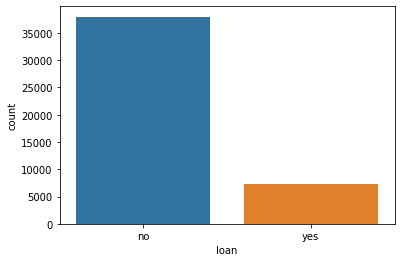

In [14]:
sns.countplot(bank_df['loan'])

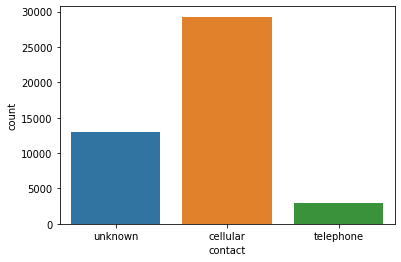

In [15]:
sns.countplot(bank_df['contact'])

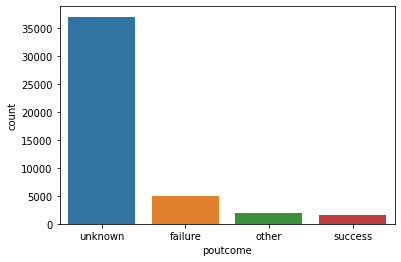

In [16]:
sns.countplot(bank_df['poutcome'])

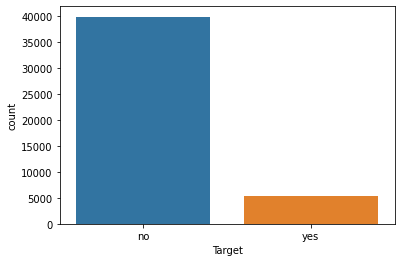

In [17]:
sns.countplot(bank_df['Target'])

In [18]:
bank_df['Target'].value_counts(normalize=True)

no     0.883015
yes    0.116985
Name: Target, dtype: float64


Процент откликов составляет всего 11,6%. Следовательно, переменная Y имеет высокий классовый дисбаланс. 

Следовательно, точность не будет надежным показателем производительности модели.

FN очень важен для этого бизнес-кейса, потому что ложноотрицательный результат - это клиент, который потенциально подпишется на получение кредита, но который был классифицирован как "не подпишется". Следовательно, наиболее важным показателем эффективности модели является отзыв

**Двумерный Анализ** 

In [19]:
#Сгруппируем числовые переменные по среднему значению для классов переменной Y
np.round(bank_df.groupby(["Target"]).mean() ,1)

,age,balance,campaign,pdays,previous
Target,,,,,
no,40.8,1303.7,2.8,36.4,0.5
yes,41.7,1804.3,2.1,68.7,1.2


- Средний баланс выше для клиентов, которые подписываются на срочный депозит, по сравнению с теми, кто этого не делает

- Количество дней, прошедших с момента последнего контакта с клиентом из предыдущей кампании, больше для людей, которые подписались

- Количество контактов, совершенных до этой кампании, также выше для клиентов, которые подписались

Все вышеперечисленные факты указывают на то, что клиенты с более высоким балансом и те, с кем часто связывались до начала кампании, как правило, подписываются на срочный депозит

**Двумерный анализ с использованием перекрестной таблицы**

In [20]:
pd.crosstab(bank_df['job'], bank_df['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target,no,yes
job,,
student,0.713220,0.286780
retired,0.772085,0.227915
unemployed,0.844973,0.155027
management,0.862444,0.137556
admin.,0.877973,0.122027
self-employed,0.881571,0.118429
unknown,0.881944,0.118056
technician,0.889430,0.110570
services,0.911170,0.088830


Самая высокая конверсия приходится на студентов (28%), а самая низкая - на "синих воротничков" (7%).

In [21]:
pd.crosstab(bank_df['marital'], bank_df['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target,no,yes
marital,,
single,0.850508,0.149492
divorced,0.880545,0.119455
married,0.898765,0.101235


In [22]:
pd.crosstab(bank_df['education'], bank_df['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target,no,yes
education,,
tertiary,0.849936,0.150064
unknown,0.864297,0.135703
secondary,0.894406,0.105594
primary,0.913735,0.086265


In [23]:
pd.crosstab(bank_df['education'], bank_df['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target,no,yes
education,,
tertiary,0.849936,0.150064
unknown,0.864297,0.135703
secondary,0.894406,0.105594
primary,0.913735,0.086265



Поскольку значение по умолчанию - да составляет всего 2% данных, а конверсия также сравнительно ниже для значения по умолчанию - да, мы можем удалить этот столбец

In [24]:
bank_df.drop(['default'], axis=1, inplace=True)

In [25]:
bank_df.columns

Index(['age', 'job', 'marital', 'education', 'balance', 'housing', 'loan',
       'contact', 'day', 'month', 'campaign', 'pdays', 'previous', 'poutcome',
       'Target'],
      dtype='object')

In [26]:
pd.crosstab(bank_df['housing'], bank_df['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target,no,yes
housing,,
no,0.832976,0.167024
yes,0.923000,0.077000


In [27]:
pd.crosstab(bank_df['loan'], bank_df['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target,no,yes
loan,,
no,0.873443,0.126557
yes,0.933186,0.066814


In [28]:
pd.crosstab(bank_df['contact'], bank_df['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target,no,yes
contact,,
cellular,0.850811,0.149189
telephone,0.865795,0.134205
unknown,0.959293,0.040707


In [29]:
pd.crosstab(bank_df['day'], bank_df['Target'], normalize='index').sort_values(by='yes',ascending=False )[0:10]

Target,no,yes
day,,
1,0.720497,0.279503
10,0.769084,0.230916
30,0.826948,0.173052
22,0.829834,0.170166
3,0.835032,0.164968
4,0.840830,0.159170
25,0.841667,0.158333
12,0.847785,0.152215
13,0.847950,0.152050


In [30]:
pd.crosstab(bank_df['month'], bank_df['Target'], normalize='index').sort_values(by='yes',ascending=False )

Target,no,yes
month,,
mar,0.480084,0.519916
dec,0.532710,0.467290
sep,0.535406,0.464594
oct,0.562331,0.437669
apr,0.803206,0.196794
feb,0.833522,0.166478
aug,0.889867,0.110133
jun,0.897772,0.102228
nov,0.898489,0.101511


Перечисление высокоуровневых результатов двумерного анализа, которые могли бы послужить указателями для выбора признаков

**Биннинг**

In [31]:
def binning(col, cut_points, labels=None):
  #Define min and max values:
  minval = col.min()
  maxval = col.max()

  #create list by adding min and max to cut_points
  break_points = [minval] + cut_points + [maxval]

  #if no labels provided, use default labels 0 ... (n-1)
  if not labels:
    labels = range(len(cut_points)+1)

  #Binning using cut function of pandas
  colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
  return colBin

**Бинниг баланс**

In [32]:
cut_points = [0,500,1000, 1500,2000]
labels = ["very low","low","medium","high", "very high", "highest"]
bank_df['balance_range'] = binning(bank_df['balance'], cut_points, labels)
bank_df['balance_range'].value_counts()

low          16385
highest       8501
very low      7280
medium        6915
high          3736
very high     2394
Name: balance_range, dtype: int64

In [33]:
cut_points = [2,3,4]
labels = ["<=2","3","4",">4"]
bank_df['campaign_range'] = binning(bank_df['campaign'], cut_points, labels)
bank_df['campaign_range'].value_counts()

<=2    30049
>4      6119
3       5521
4       3522
Name: campaign_range, dtype: int64

In [34]:
bank_df.drop(['balance', 'campaign'], axis=1, inplace=True)
bank_df.columns

Index(['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact',
       'day', 'month', 'pdays', 'previous', 'poutcome', 'Target',
       'balance_range', 'campaign_range'],
      dtype='object')

In [35]:
X = bank_df.drop("Target" , axis=1)
y = bank_df["Target"]   # выбераем все строки и 17-й столбец, который является классификацией"Yes", "No"
X = pd.get_dummies(X, drop_first=True)

In [36]:
# прохождение 70:30 тренировочного и тестового набора
test_size = 0.30

# Случайный набор чисел для повторяемости кода
seed = 7

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [37]:
X_train.shape,X_test.shape

((31647, 75), (13564, 75))

In [38]:
#создание экземпляра дерева решений в качестве модели по умолчанию
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [39]:
# Является ли эта модель моделью overfit? 
y_pred = dt_model.predict(X_test)
print(dt_model.score(X_train, y_train))
print(dt_model.score(X_test , y_test))

0.9987360571302177
0.8352993217340018


Примечание:

• Дерево решений является непараметрическим алгоритмом и, следовательно, легко поддается переобучению. Это видно по разнице в баллах при обучении и тестировании

• В методах ансамбля необходимо, чтобы несколько экземпляров (каждый из которых отличается от другого) и каждый экземпляр был полностью приспособлен

• Возможно, что разные экземпляры будут допускать разные ошибки при классификации, и когда их объединим в группу, их ошибки будут устранены, что даст преимущество в виде меньшей предвзятости и меньших общих ошибок отклонения.

**Матрица путаницы**

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score

print(confusion_matrix(y_test, y_pred))

print(accuracy_score(y_test, y_pred))


print(recall_score(y_test, y_pred,average="binary", pos_label="yes"))

[[10845  1185]
 [ 1049   485]]
0.8352993217340018
0.3161668839634941


Показатель отзыва относительно низок, поэтому это должно быть улучшено в модели

In [41]:
clf_pruned = DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth=3, min_samples_leaf=5)
clf_pruned.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5,
                       random_state=100)

**Визуализирующее дерево**

In [42]:
#for визуализирующее дерево

!pip install pydotplus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


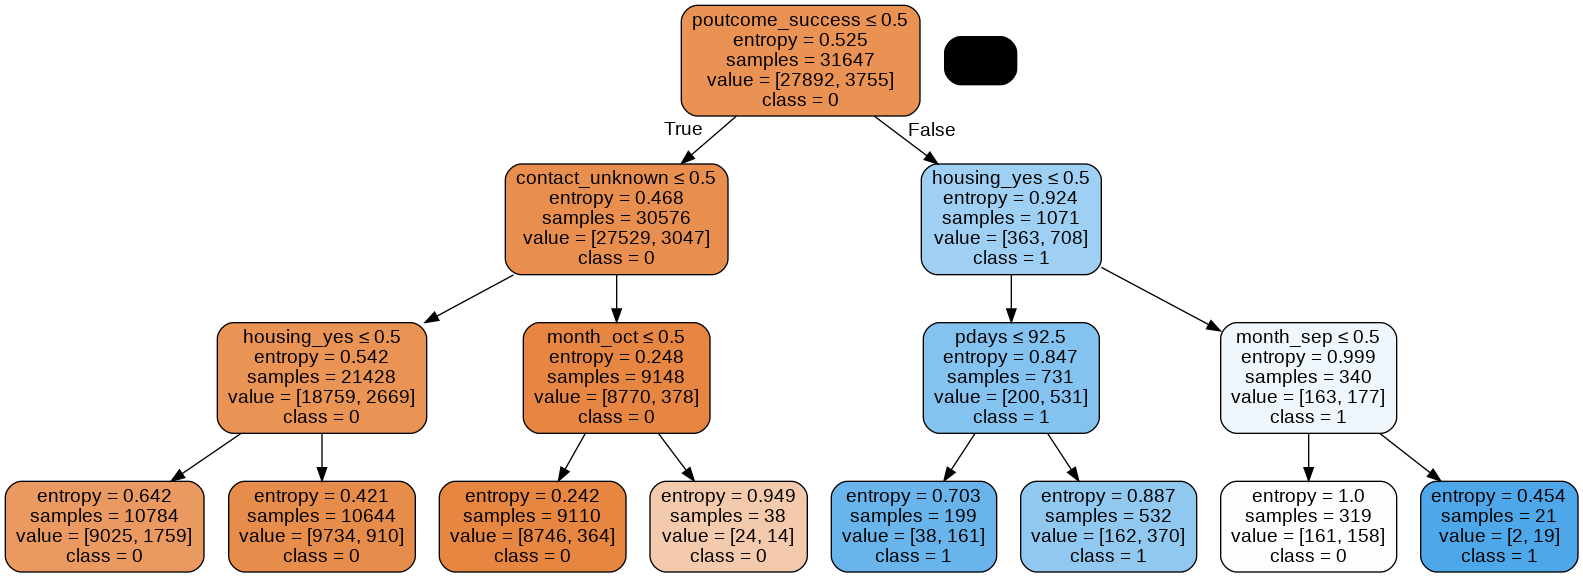

In [43]:
from sklearn.tree import export_graphviz
#from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import graphviz
import six
import sys
from io import StringIO
sys.modules['sklearn.externals.six'] = six

feature_cols = X_train.columns
dot_data = StringIO()
export_graphviz(clf_pruned, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('bank_pruned.png')
Image(graph.create_png())

**Вычисление важности объекта**

In [44]:
feat_importance = clf_pruned.tree_.compute_feature_importances(normalize=False)


feat_imp_dict = dict(zip(feature_cols, clf_pruned.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.sort_values(by=0, ascending=False)[0:10] #Top 10 features

,0
poutcome_success,0.652601
contact_unknown,0.202537
housing_yes,0.121260
month_oct,0.014702
month_sep,0.005419
pdays,0.003482
day_23,0.000000
day_24,0.000000
day_25,0.000000
day_26,0.000000


In [45]:
preds_pruned = clf_pruned.predict(X_test)
preds_pruned_train = clf_pruned.predict(X_train)

In [46]:
acc_DT = accuracy_score(y_test, preds_pruned)
recall_DT = recall_score(y_test, preds_pruned, average="binary", pos_label="yes")

Сохраним результаты точности для каждой модели во фрейме данных для окончательного сравнения

In [47]:
resultsDf = pd.DataFrame({'Method':['Decision Tree'], 'accuracy': acc_DT, 'recall': recall_DT})
resultsDf = resultsDf[['Method', 'accuracy', 'recall']]
resultsDf

,Method,accuracy,recall
0,Decision Tree,0.893689,0.134941


Переоснащение уменьшается после обрезки, и отзыв резко сократился

Применим модель случайного леса и выведим точность модели случайного леса

In [48]:
from sklearn.ensemble import RandomForestClassifier
rfcl = RandomForestClassifier(n_estimators = 50)
rfcl = rfcl.fit(X_train, y_train)

In [49]:
pred_RF = rfcl.predict(X_test)
acc_RF = accuracy_score(y_test, pred_RF)
recall_RF = recall_score(y_test, pred_RF, average="binary", pos_label="yes")

In [50]:
tempResultsDf = pd.DataFrame({'Method':['Random Forest'], 'accuracy': [acc_RF], 'recall': [recall_RF]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy', 'recall']]
resultsDf

,Method,accuracy,recall
0,Decision Tree,0.893689,0.134941
0,Random Forest,0.891699,0.219035


**Применение алгоритма ансамбля Adaboost для одних и тех же данных и печать точности**

In [51]:
from sklearn.ensemble import AdaBoostClassifier
abcl = AdaBoostClassifier( n_estimators= 200, learning_rate=0.1, random_state=22)
abcl = abcl.fit(X_train, y_train)

In [52]:
pred_AB =abcl.predict(X_test)
acc_AB = accuracy_score(y_test, pred_AB)
recall_AB = recall_score(y_test, pred_AB, pos_label='yes')

In [53]:
tempResultsDf = pd.DataFrame({'Method':['Adaboost'], 'accuracy': [acc_AB], 'recall':[recall_AB]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy', 'recall']]
resultsDf
resultsDf

,Method,accuracy,recall
0,Decision Tree,0.893689,0.134941
0,Random Forest,0.891699,0.219035
0,Adaboost,0.893689,0.151890


**Применим алгоритм классификатора упаковки**

In [54]:
from sklearn.ensemble import BaggingClassifier

bgcl = BaggingClassifier(n_estimators=100, max_samples= .7, bootstrap=True, oob_score=True, random_state=22)
bgcl = bgcl.fit(X_train, y_train)

In [55]:
pred_BG =bgcl.predict(X_test)
acc_BG = accuracy_score(y_test, pred_BG)
recall_BG = recall_score(y_test, pred_BG, pos_label='yes')

In [56]:
tempResultsDf = pd.DataFrame({'Method':['Bagging'], 'accuracy': [acc_BG], 'recall':[recall_BG]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy', 'recall']]
resultsDf
resultsDf

,Method,accuracy,recall
0,Decision Tree,0.893689,0.134941
0,Random Forest,0.891699,0.219035
0,Adaboost,0.893689,0.151890
0,Bagging,0.889487,0.239896


In [57]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators = 200, learning_rate = 0.1, random_state=22)
gbcl = gbcl.fit(X_train, y_train)

In [58]:
pred_GB =gbcl.predict(X_test)
acc_GB = accuracy_score(y_test, pred_GB)
recall_GB = recall_score(y_test, pred_GB, pos_label='yes')

In [59]:
tempResultsDf = pd.DataFrame({'Method':['Gradient Boost'], 'accuracy': [acc_GB], 'recall':[recall_GB]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy', 'recall']]
resultsDf
resultsDf

,Method,accuracy,recall
0,Decision Tree,0.893689,0.134941
0,Random Forest,0.891699,0.219035
0,Adaboost,0.893689,0.151890
0,Bagging,0.889487,0.239896
0,Gradient Boost,0.894279,0.212516


Упаковка обеспечивает в целом наилучшие характеристики модели. Однако, необходимо обратить внимание,что отзыв по-прежнему очень низок.